# Quality control on indices

This notebook performs some quality control on the data products produced in the CORDEX climate indices data pipeline.

Run the cell below to set up the environment:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import xarray as xr
import xclim.indices as xci
from xclim.core.calendar import percentile_doy
from xclim.core.units import convert_units_to, to_agg_units
from xclim.indices.generic import threshold_count
# project
from config import *

## Annual indices

This section will spot check the dataset of indices derived at an annual time scale, which are saved to the `annual_indices.nc` file.

We will look at some test locations and spot check calculations for all indices that are currently computed.

Define some locations to check:

In [2]:
check_coords = [(-146.3499, 61.1309), (-156.7886, 71.2906)] # (lat, lon)

Set a couple year-model-scenario combinations to check:

In [3]:
# arbitrary
check_args = [
    # (model, scenario, year)
    {"model": "NCC-NorESM1-M_SMHI-RCA4", "scenario": "hist", "year": 1995},
    {"model": "MPI-M-MPI-ESM-LR_SMHI-RCA4-SN", "scenario": "rcp85", "year": 2095},
]

Open connection to annual indices dataset:

In [4]:
ds = xr.open_dataset(indices_fp)

And define a function to perform the task of extracting the cordex data from `cordex_dir`:

In [5]:
def extract_cordex(args, varname, coords):
    model, scenario, time = list(args.values())
    if type(time) == int:
        time_sl = slice(f"{time}-01-01", f"{time}-12-31")
    elif type(time) == slice:
        time_sl = time
    base_fp = cordex_dir.joinpath(scenario, varname, temp_fn.format(scenario, varname, model))
    with xr.open_dataset(base_fp) as cdx_ds:
        da = (
            cdx_ds[varname]
            .sel(time=time_sl)
            .sel(lat=coords[0], lon=coords[1], method="nearest")
        )
    
    return da

We are now ready to begin checking the values.

Each of the below code blocks include assertions for each of the coordinate / `args` combinations. If they run without exception, then we can consider that a passing test.

#### `rx1day` - max 1-day precip

In [6]:
varname = "pr"
index = "rx1day"
for args in check_args:
    for coords in check_coords:
        da = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        # convert to mm from flux using conversion factor of 8640 provided by John W (for kg m-2 s-1 to cm, * 10 for mm)
        calc = round(np.max(da.values) * 86400, 1)
        assert calc == test

#### `rx5day` - max 5-day precip

In [7]:
varname = "pr"
index = "rx5day"
for args in check_args:
    for coords in check_coords:
        da = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        # convert to mm from flux using conversion factor of 8640 provided by John W (for kg m-2 s-1 to cm, * 10 for mm)
        calc = round(np.max(da.rolling(time=5).sum()).values * 86400, 1)
        assert calc == test

#### `r10mm` - Heavy precip days

Number of days in a year with over 10mm of precip

In [8]:
varname = "pr"
index = "r10mm"
for args in check_args:
    for coords in check_coords:
        da = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        # convert to mm from flux using conversion factor of 8640 provided by John W (for kg m-2 s-1 to cm, * 10 for mm)
        calc = ((da.values * 86400) > 10).sum()
        assert calc == test

#### `cwd` - Maximum consecutive wet days

Threshold of 1mm / day

In [9]:
varname = "pr"
index = "cwd"
for args in check_args:
    for coords in check_coords:
        da = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        # wet days
        wd_arr = (da * 86400) > 1
        # ugly but this is finding the max sequence of wet days
        acc = []
        seq = []
        for x in wd_arr.values:
            if x:
                seq.append(x)
            else:
                acc.append(seq)
                seq=[]
        calc = np.max([len(seq) for seq in acc])
        assert calc == test

#### `cdd` - Maximum consecutive dry days

Threshold of 1mm / day

In [10]:
varname = "pr"
index = "cdd"
for args in check_args:
    for coords in check_coords:
        da = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        # dry days
        dd_arr = (da * 86400) < 1
        # ugly but this is finding the max sequence of dry days
        acc = []
        seq = []
        for x in dd_arr.values:
            if x:
                seq.append(x)
            else:
                acc.append(seq)
                seq=[]
        calc = np.max([len(seq) for seq in acc])
        assert calc == test

#### `wndd` - Number of windy days

Threshold of 10 m/s

In [11]:
varname = "sfcWind"
index = "wndd"
for args in check_args:
    for coords in check_coords:
        da = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        calc = (da > 10).values.sum()
        assert calc == test

#### `hsd` - heavy snow days

In [12]:
varname = "prsn"
index = "hsd"
for args in check_args:
    for coords in check_coords:
        da = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        # convert to cm from flux using conversion factor of 8640 provided by John W (for kg m-2 s-1 to cm)
        calc = np.round(np.sort(da.values)[-5:].mean() * 8640, 1).astype(np.float32)
        assert calc == test

#### `hd` - hot day

In [13]:
varname = "tasmax"
index = "hd"
for args in check_args:
    for coords in check_coords:
        arr = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        calc = np.round(np.sort(arr)[-6] - 273.15, 1).astype(np.float32)
        assert calc == test

#### `cd` - cold day

In [14]:
varname = "tasmin"
index = "cd"
for args in check_args:
    for coords in check_coords:
        arr = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        calc = np.round(np.sort(arr)[5] - 273.15, 1).astype(np.float32)
        assert calc == test

#### `wsdi` - Warm spell duration index

Number of days inside spells of a minimum number of consecutive days where the daily maximum temperature is above the 90th percentile. The 90th percentile should be computed for a 5-day moving window, centered on each calendar day in the 1976-2005 period.

In [15]:
varname = "tasmax"
index = "wsdi"
for args in check_args:
    for coords in check_coords:
        tasmax = extract_cordex(args, varname, coords)
        if args["scenario"] != "hist":
            hist_args = args.copy()
            hist_args.update({"scenario": "hist", "year": slice("1976-01-01", "2005-12-31")})
            tasmax_hist = extract_cordex(hist_args, varname, coords)
        else:
            tasmax_hist = tasmax
        tasmax_per = percentile_doy(tasmax_hist, per=90).sel(percentiles=90)
        calc = xci.warm_spell_duration_index(tasmax, tasmax_per, window=6, freq="YS").drop("percentiles")
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        assert calc == test

#### `csdi` - Cold spell duration index

Number of days inside spells of a minimum number of consecutive days where the daily minimum temperature is below the 10th percentile. The 10th percentile should be computed for a 5-day moving window, centered on each calendar day in the 1976-2005 period.

In [16]:
varname = "tasmin"
index = "csdi"
for args in check_args:
    for coords in check_coords:
        tasmin = extract_cordex(args, varname, coords)
        if args["scenario"] != "hist":
            hist_args = args.copy()
            hist_args.update({"scenario": "hist", "year": slice("1976-01-01", "2005-12-31")})
            tasmin_hist = extract_cordex(hist_args, varname, coords)
        else:
            tasmin_hist = tasmin
        tasmin_per = percentile_doy(tasmin_hist, per=10).sel(percentiles=10)
        calc = xci.cold_spell_duration_index(tasmin, tasmin_per, window=6, freq="YS").drop("percentiles")
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        assert calc == test

#### `su` - Summer days

Number of days above 25C

In [17]:
varname = "tasmax"
index = "su"
for args in check_args:
    for coords in check_coords:
        arr = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        calc = ((arr - 273.15) > 25).sum()
        assert calc == test

#### `cd` - Deep winter days

Number of days below -30

In [18]:
varname = "tasmin"
index = "dw"
for args in check_args:
    for coords in check_coords:
        arr = extract_cordex(args, varname, coords)
        test = ds[index].sel(args).sel(lat=coords[0], lon=coords[1], method="nearest")
        calc = ((arr - 273.15) < -30).sum()
        assert calc == test

## Location extractions

This section will validate the decadal and era-based extractions from the annual indices dataset made at select locations and saved to excel and CSV format.

We will just rely on the same model-scenario combinations as above for simplicity, but we will then check the aggregated values - min, mean and max - for all available summary periods, for both types of temporal summaries. Run this monster loop:

In [19]:
# list of the index variable names available from config
index_list = [name for index_list in idx_varname_lu.values() for name in index_list]
for loc in ["Kaktovik", "Ketchikan"]:
    lat, lon = locations[loc]
    for args in check_args:
        model, scenario, _ = args
        era_df = pd.read_excel(idx_era_summary_fp, loc)
        decade_df = pd.read_excel(idx_decade_summary_fp, loc) 
        for index in index_list:
            query_str = f"model == '{model}' & scenario == '{scenario}' & idx_var == '{index}'"
            # check era summaries
            temp_df = era_df.query(query_str)
            eras = np.unique(temp_df.era)
            for era in eras:
                start_year, end_year = era.split("-")
                arr = ds[index].sel(lat=lat, lon=lon, method="nearest").sel(
                    model=model, scenario=scenario, year=slice(start_year, end_year)
                )
                assert arr.mean() == temp_df.query(f"era == {era}")["mean"]
                assert arr.min() == temp_df.query(f"era == {era}")["min"]
                assert arr.max() == temp_df.query(f"era == {era}")["max"]
                
            temp_df = decade_df.query(query_str)
            decades = np.unique(temp_df.decade)
            for decade in decades:
                start_year, end_year = decade.split("-")
                arr = ds[index].sel(lat=lat, lon=lon, method="nearest").sel(
                    model=model, scenario=scenario, year=slice(start_year, end_year)
                )
                assert arr.mean() == temp_df.query(f"decade == {era}")["mean"]
                assert arr.min() == temp_df.query(f"decade == {era}")["min"]
                assert arr.max() == temp_df.query(f"decade == {era}")["max"]

And if there are no errors, we've verified all summaries for two model-scenario combinations, for two locations.

That concludes the validation of data products. Close the connection to the annual indices dataset:

In [20]:
ds.close()

## Summary plots

### Decadal mean barplots

Have a look at some of the decadal summary barplots and do a spot check for that the bars and whiskers appear to match expecatations.

Define a function to read and plot the PNGs:

In [21]:
%matplotlib inline

def plot_decadal_barplot(index, aggr_var, location):
    fp = decadal_summary_dir.joinpath(
        "barplots",
        index,
        "barplot_{}_{}_{}.png".format(aggr_var, index, location)
    )
    img = mpimg.imread(fp)
    fig, ax = plt.subplots(figsize=(10, 6))
    imgplot = plt.imshow(img)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


And define a function to get the expected values for the bars and whiskers. The `aggr_var` specifies the method used to aggregate among years within a decade. Compute that decadal summary for each model, then take the mean of that value to get the expected bar height for a given decade/scenario. The whiskers will be the min and max of those summaries. This function should print out the lower whisker (min), bar height (mean), and upper whisker (max):

In [22]:
def compute_expected_values(index, aggr_var, location, scenario, decade_start):
    """Computes the expected values for a single bar (+ whiskers) in the decadal summary barplots)
    """
    lat, lon = locations[location]
    decade_sl = slice(decade_start, decade_start + 9)
    
    # using the DataArray methods to access teh skipna arg
    aggr_func = {
        "min": xr.DataArray.min, 
        "mean": xr.DataArray.mean, 
        "max": xr.DataArray.max
    }[aggr_var]

    decadal_summaries = ds[index].sel(
        lat=lat, lon=lon, method="nearest"
    ).sel(
        year=decade_sl, scenario=scenario
    ).groupby("model").apply(aggr_func, skipna=True).dropna(dim="model")
    
    print((
        "Expected values for {}, {}:\n"
        "   lower whisker: {}\n"
        "   bar height: {}\n"
        "   upper whisker: {}"
    ).format(
            decade_start, scenario,
            decadal_summaries.values.min().round(1),
            decadal_summaries.values.mean().round(1),
            decadal_summaries.values.max().round(1),
        )
    )
    
    return

Then plot some... plots and do some eyeball-based verifications.

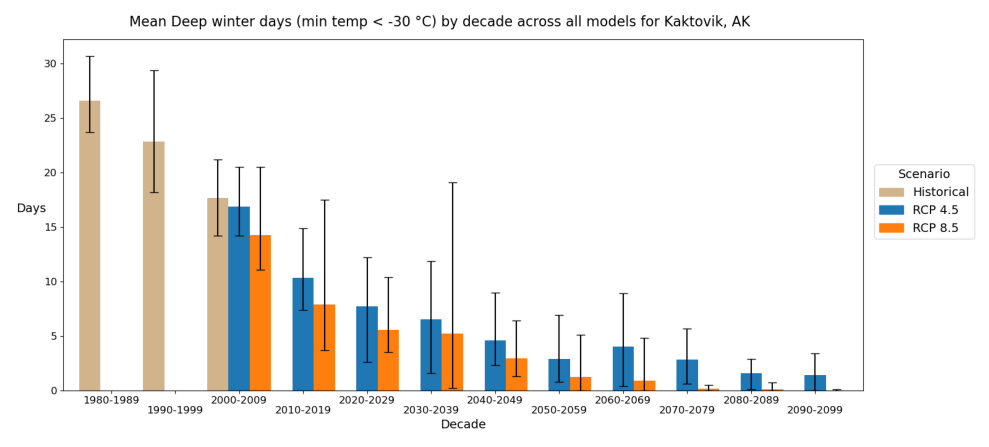

In [23]:
index = "dw"
aggr_var = "mean"
location = "Kaktovik"
plot_decadal_barplot(index, aggr_var, location)

In [24]:
compute_expected_values(index, aggr_var, location, "rcp45", 2040)

Expected values for 2040, rcp45:
   lower whisker: 2.3
   bar height: 4.6
   upper whisker: 9.0


In [25]:
compute_expected_values(index, aggr_var, location, "hist", 1980)

Expected values for 1980, hist:
   lower whisker: 23.7
   bar height: 26.6
   upper whisker: 30.7


In [26]:
compute_expected_values(index, aggr_var, location, "rcp45", 2000)

Expected values for 2000, rcp45:
   lower whisker: 8.5
   bar height: 14.9
   upper whisker: 17.2


In [27]:
compute_expected_values(index, aggr_var, location, "rcp85", 2090)

Expected values for 2090, rcp85:
   lower whisker: 0.0
   bar height: 0.0
   upper whisker: 0.1


Check out another location and index. Note - these summary charts could have been generated for max and min decadal aggregations as well, although the current default is mean only. Change the `aggr_var` below to `"mean"` if the min/max decadal aggregate methods were not used, as those summary plots won't be available. 

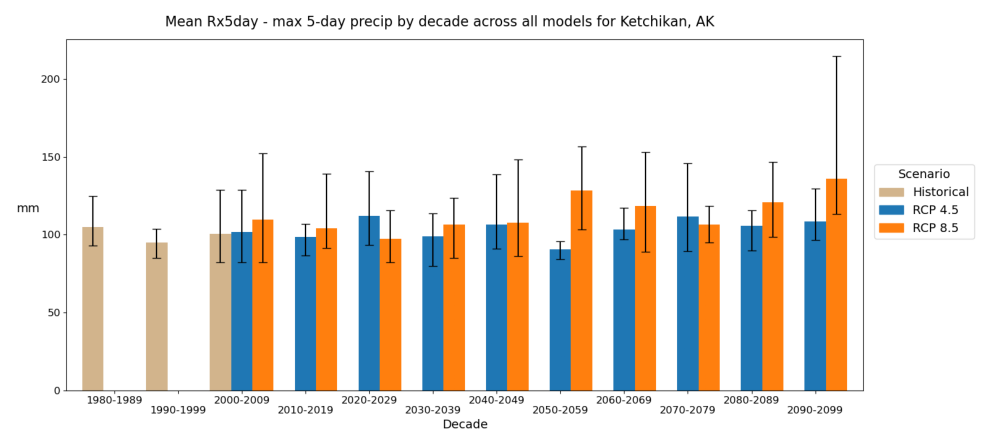

In [28]:
index = "rx5day"
aggr_var = "max"
location = "Ketchikan"
plot_decadal_barplot(index, aggr_var, location)

In [29]:
compute_expected_values(index, aggr_var, location, "rcp45", 2010)

Expected values for 2010, rcp45:
   lower whisker: 86.8
   bar height: 98.6
   upper whisker: 106.9


In [30]:
compute_expected_values(index, aggr_var, location, "hist", 1990)

Expected values for 1990, hist:
   lower whisker: 85.1
   bar height: 94.8
   upper whisker: 103.8


In [31]:
compute_expected_values(index, aggr_var, location, "rcp85", 2000)

Expected values for 2000, rcp85:
   lower whisker: 74.2
   bar height: 102.7
   upper whisker: 152.3


In [32]:
compute_expected_values(index, aggr_var, location, "rcp85", 2090)

Expected values for 2090, rcp85:
   lower whisker: 113.3
   bar height: 135.9
   upper whisker: 214.8


The end!